In [1]:
import os
import fastmri
from fastmri.data import transforms
import numpy as np
import torch
import pytorch_lightning as pl
import PIL
import pandas as pd
import h5py
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
fastmri.__version__

'0.1.2a20210917b'

In [86]:
brain_mri_datapath = "/data/projects/recon/data/public/fastmri/brain/data/FLAIR/multicoil_train/"
mri_files = os.listdir(brain_mri_datapath)

annotation_path = "/home/lgdejong/scratch/projects/RecSeg/annotations/"
annotation_file = "brain.csv" 
annotation_file_list = "brain_file_list.csv"

annatations_df = pd.read_csv(os.path.join(annotation_path, annotation_file), index_col=None)
file_list_df = pd.read_csv(os.path.join(annotation_path, annotation_file_list), header=None)
file_names = file_list_df[0].to_list()
file_names = [i+".h5" for i in file_names]

non_lesion_files = annatations_df.loc[annatations_df['label'] != 'Nonspecific white matter lesion']
non_lesion_files = non_lesion_files['file'].unique()

annotated_file_names = set(mri_files).intersection(set(file_names))
annotated_file_names.difference_update(set(non_lesion_files))
annotated_file_names = list(annotated_file_names)
annotated_file_names.sort()
print(f"Sample count: {len(annotated_file_names)}")

Sample count: 342


In [87]:
def get_label(data_frame, file_name, slice=None):
    results = {}

    if file_name[-3:] == '.h5':
        file_name = file_name[:-3]

    file_label = data_frame.loc[data_frame['file'] == file_name]

    if slice is None:
        slice = list(file_label['slice'].unique())
    else:
        slice = [slice]

    for i in slice:
        label = file_label.loc[file_label['slice'] == i].values.tolist()
        results[i] = label

    return results

def kspace2image(mri_kspace, slice=None):
    results = []

    if slice:
        slice = [slice]
    else:
        slice = [i for i in range(mri_kspace.shape[0])]

    for i in slice:
        kspace_slice = mri_kspace[i]
        kspace_slice = transforms.to_tensor(kspace_slice)
        slice_image = fastmri.ifft2c(kspace_slice)
        slice_image = fastmri.complex_abs(slice_image)
        if len(kspace_slice.shape) == 4:
            slice_image = fastmri.rss(slice_image, dim=0)
        slice_image = np.abs(slice_image.numpy())
        results.append(slice_image)

    return np.stack(results, axis=0)

label = get_label(annatations_df, annotated_file_names[0])
print(label.keys(), label[0])

dict_keys([0, 1, 2, 3, 4, 7, 9]) [['file_brain_AXFLAIR_200_6002429', 0, 'No', 187.0, 221.0, 14.0, 22.0, 'Nonspecific white matter lesion'], ['file_brain_AXFLAIR_200_6002429', 0, 'No', 109.0, 203.0, 30.0, 62.0, 'Nonspecific white matter lesion'], ['file_brain_AXFLAIR_200_6002429', 0, 'No', 182.0, 101.0, 9.0, 15.0, 'Nonspecific white matter lesion'], ['file_brain_AXFLAIR_200_6002429', 0, 'No', 134.0, 96.0, 8.0, 14.0, 'Nonspecific white matter lesion']]


In [98]:
def center_crop(data, shape):
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]

def plot_bounding_box(image, labels):
    plotted_image = PIL.ImageDraw.Draw(image)
    for label in labels:
        _, _, _, x0, y0, w, h, label_txt = label
        x1 = x0 + w
        y1 = y0 + h
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline="white")
        plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
    return np.array(image)

def meta_bounding_box_plot(image_tensor, label_dict):
    image_tensor = image_tensor[:, ::-1, :]
    slices, h, w = image_tensor.shape
    crop = min(h, w)
    image_tensor = center_crop(image_tensor, shape=(crop, crop))
    for i in range(slices):
        image = image_tensor[i, :, :]
        image = (np.maximum(image,0) / image.max()) * 255
        image = PIL.Image.fromarray(np.uint8(image))
        if i in label_dict.keys():
            image =  plot_bounding_box(image, label_dict[i])
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.show()

In [99]:
def read_kspace(root, filename):
    path = os.path.join(root, filename)
    hf = h5py.File(path)

    try:
        kspace = hf["kspace"]
    except KeyError:
        print("H5 file does not contain the kspace key.")
    return kspace

file_brain_AXFLAIR_200_6002429.h5


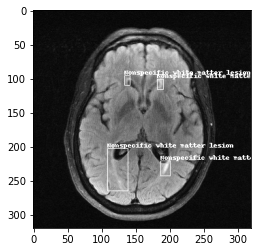

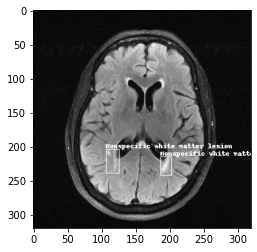

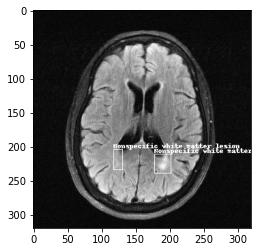

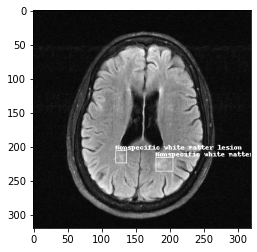

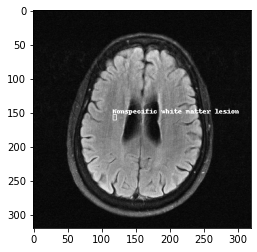

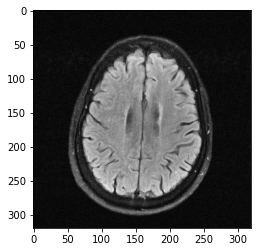

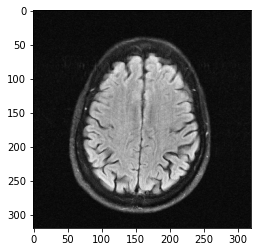

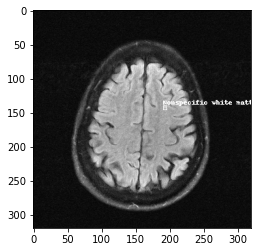

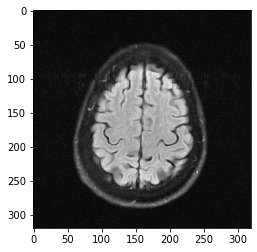

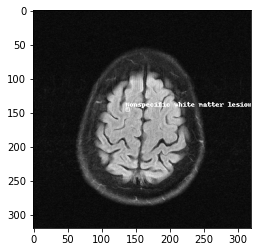

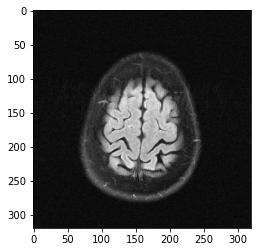

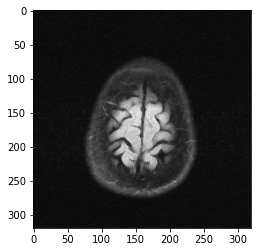

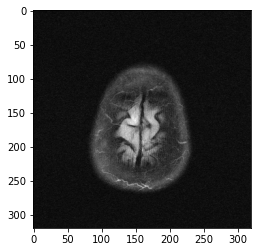

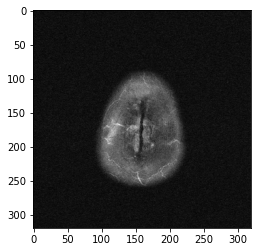

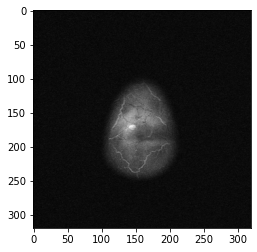

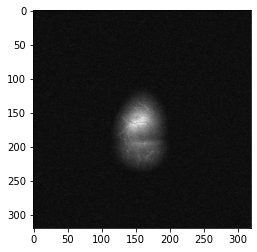

In [101]:
print(annotated_file_names[0])
kspace = read_kspace(brain_mri_datapath, annotated_file_names[0])
label = get_label(annatations_df, annotated_file_names[0])
images = kspace2image(kspace)
meta_bounding_box_plot(images, label)

Find out if the segmentation masks match up with SKM-TEA data.

In [12]:
raw_data_dir = "/data/projects/recon/data/public/qdess/v1-release/files_recon_calib-24/"
seg_data_dir = "/data/projects/recon/data/public/qdess/v1-release/segmentation_masks/raw-data-track/"

raw_files = os.listdir(raw_data_dir)
seg_files = os.listdir(seg_data_dir)

raw_files.sort()
seg_files.sort()

In [15]:
print(raw_files[:10])
print(seg_files[:10])

['MTR_001.h5', 'MTR_005.h5', 'MTR_006.h5', 'MTR_008.h5', 'MTR_010.h5', 'MTR_013.h5', 'MTR_015.h5', 'MTR_016.h5', 'MTR_018.h5', 'MTR_019.h5']
['MTR_001.nii.gz', 'MTR_005.nii.gz', 'MTR_006.nii.gz', 'MTR_008.nii.gz', 'MTR_010.nii.gz', 'MTR_013.nii.gz', 'MTR_015.nii.gz', 'MTR_016.nii.gz', 'MTR_018.nii.gz', 'MTR_019.nii.gz']
